![MLA Logo](https://drive.corp.amazon.com/view/mrruckma@/MLA_headerv2.png?download=true)

### 1. Download and Read the Dataset


#### We have the following classes:
### * Class 0: Inconclusive
### * Class 1: Two wheels
### * Class 2: Four wheels
### * Class 3: Not luggage
### * Class 4: Zero wheels


We are reading it into a Data Frame. 

In [38]:
#!pip install -U scikit-image
#!pip install -U numpy

#Let's read in our training data. ASINs correspond to those in Leaderboard's ID.
import pandas as pd
import boto3

df = pd.read_pickle("./training_data.pkl")
tf = pd.read_pickle("./test_data.pkl")


Let's plot some images below.

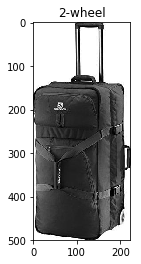

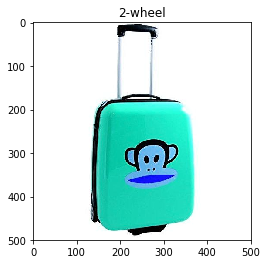

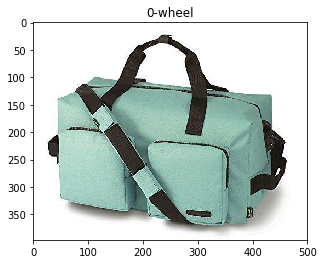

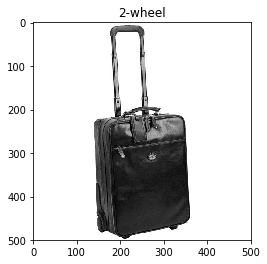

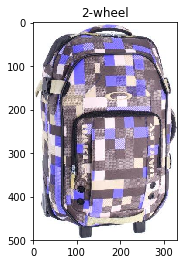

In [3]:
import matplotlib.pyplot as plt

classes = ['inconclusive', '2-wheel', '4-wheel', 'not-luggage', '0-wheel']

plt.imshow(df["data"][551])
plt.title(classes[df["label"][551]])
plt.show()

plt.imshow(df["data"][1119])
plt.title(classes[df["label"][1119]])
plt.show()

plt.imshow(df["data"][156])
plt.title(classes[df["label"][156]])
plt.show()

plt.imshow(df["data"][1526])
plt.title(classes[df["label"][1526]])
plt.show()

plt.imshow(df["data"][15])
plt.title(classes[df["label"][15]])
plt.show()

### 2. Split the dataset and Process Images
#### * We split the original training dataset into Training (90%) and Validation (10%) and use the test dataset for testing. 
#### * We will process images by resizing to 224x224 and converting (row, column, channel) to (channel, row, column)

In [39]:
import numpy as np
from skimage.transform import resize

# Let's split to data into training (80%), validation (10%) and test (10%) subsets.
tr_pct=0.9
train_indices = np.arange(0, int(tr_pct*len(df)))
val_indices = np.arange(int(tr_pct*len(df)), int(len(df)))
test_indices = np.arange(0, len(tf))

train_df = df.iloc[train_indices]
val_df = df.iloc[val_indices]
test_df = tf.iloc[test_indices]

del df
del tf

def getImages(images):
    # Create the image holder array
    image_arr = np.zeros((images.shape[0], 3, 224, 224))
    
    # Iterate through the image data
    for i, im in enumerate(images):
        # Get image from the data column of the current row
        
        # We need a fixed size input, our images have different sizes, let's pick 224x224.
        # Resize image below
        im = resize(im, output_shape=(224, 224))
        
        # Gluon/mxnet expects images in this format (channel, row, column)
        # This is the opposite of (row, column, channel), let's fix it
        im = np.moveaxis(im, -1, 0)
        
        # Assign the value in the image array
        image_arr[i] = im

    return image_arr
    
train_images, train_labels = getImages(train_df["data"].values), train_df["label"].values
validation_images, validation_labels = getImages(val_df["data"].values), val_df["label"].values

### 3. Plot the class distribution

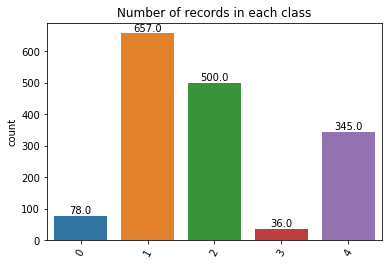

In [40]:
import matplotlib.pyplot as plt
import seaborn as sb

plt.figure()
ax = sb.countplot(x=train_labels, y = None)
for p in ax.patches:
    x=p.get_bbox().get_points()[:,0]
    y=p.get_bbox().get_points()[1,1]
    ax.annotate(y, (x.mean(), y), ha='center', va='bottom') 
plt.xticks(rotation=60)
plt.title('Number of records in each class')
plt.show()

### 4. Confusion Matrix 
#### We have the following function to plot confusion matrix. We will call this function to plot confusion matrix for our validation data after each epoch (one full pass through the training dataset)


In [41]:
import seaborn as sn
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

def plot_confusion_matrix(y_true, y_pred):
    cm = confusion_matrix(y_true, y_pred)
    df_cm = pd.DataFrame(cm, index = [i for i in classes], columns = [i for i in classes])
    plt.figure(figsize = (5, 5))
    plt.title('Validation Confusion Matrix')
    sn.heatmap(df_cm, annot=True)
    plt.show()

### 5. Training and Validation
#### We will do the following:
#### * Create a simple Convolutional Neural Network (2 conv-pool pairs + flattening + softmax)
#### * Use the following hyper-parameters: batch size, epochs, learning rate. You can experiment with different values, but we will discuss those in greater detail tomorrow
#### * Calculate the loss and accuracy for training and validation at each epoch and print them at the end of each epoch.
#### * Plot the confusion matrix at the end of each epoch. 

Epoch 0, training loss: 1.59, validation loss: 1.38, training accuracy: 0.33, validation accuracy: 0.36


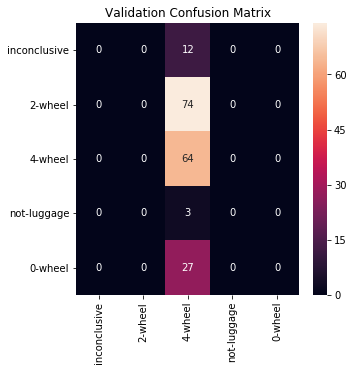

Epoch 1, training loss: 1.34, validation loss: 1.27, training accuracy: 0.35, validation accuracy: 0.41


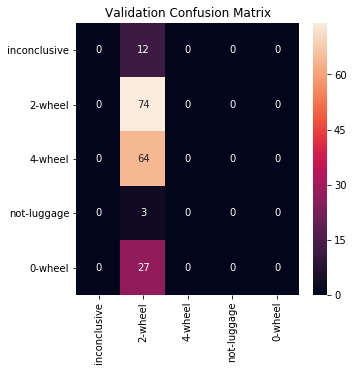

Epoch 2, training loss: 1.29, validation loss: 1.27, training accuracy: 0.38, validation accuracy: 0.41


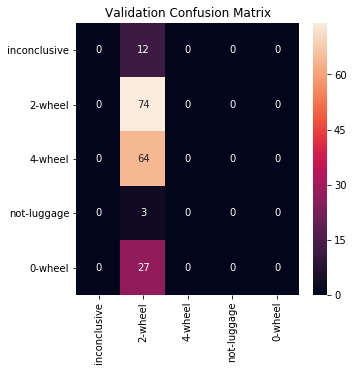

Epoch 3, training loss: 1.28, validation loss: 1.26, training accuracy: 0.41, validation accuracy: 0.41


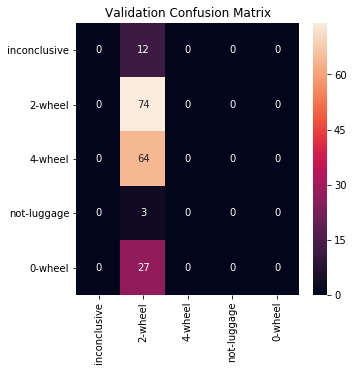

Epoch 4, training loss: 1.27, validation loss: 1.25, training accuracy: 0.42, validation accuracy: 0.41


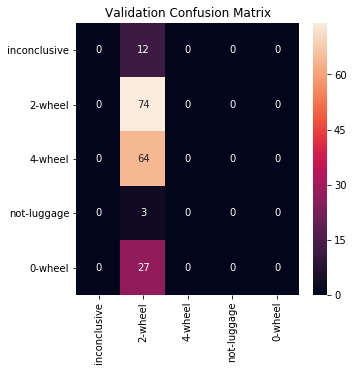

Epoch 5, training loss: 1.25, validation loss: 1.24, training accuracy: 0.42, validation accuracy: 0.41


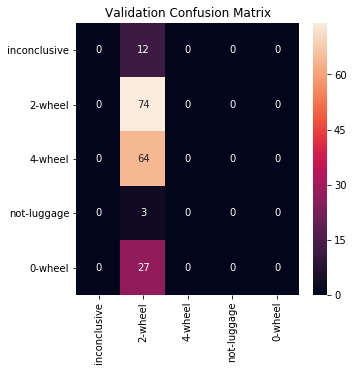

Epoch 6, training loss: 1.24, validation loss: 1.24, training accuracy: 0.43, validation accuracy: 0.41


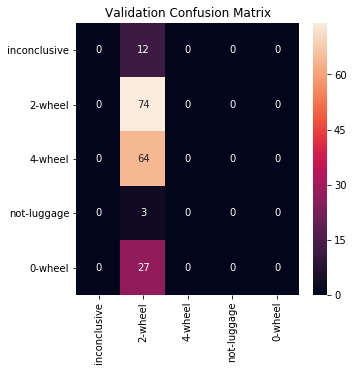

Epoch 7, training loss: 1.22, validation loss: 1.24, training accuracy: 0.42, validation accuracy: 0.41


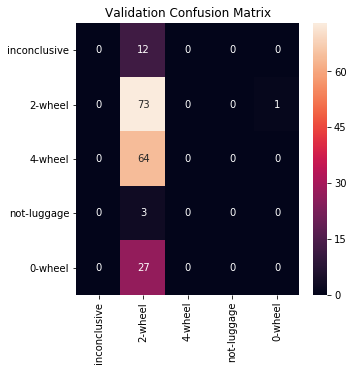

Epoch 8, training loss: 1.20, validation loss: 1.32, training accuracy: 0.43, validation accuracy: 0.43


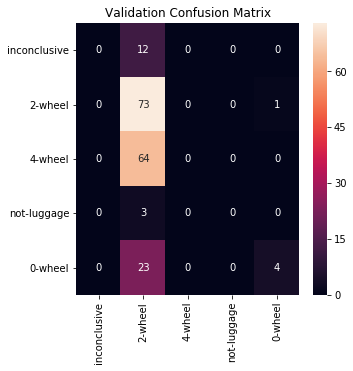

Epoch 9, training loss: 1.24, validation loss: 1.18, training accuracy: 0.42, validation accuracy: 0.49


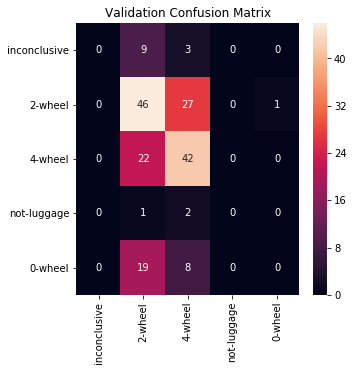

Epoch 10, training loss: 1.19, validation loss: 1.21, training accuracy: 0.46, validation accuracy: 0.41


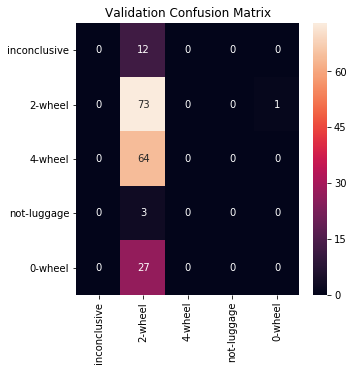

Epoch 11, training loss: 1.17, validation loss: 1.15, training accuracy: 0.46, validation accuracy: 0.48


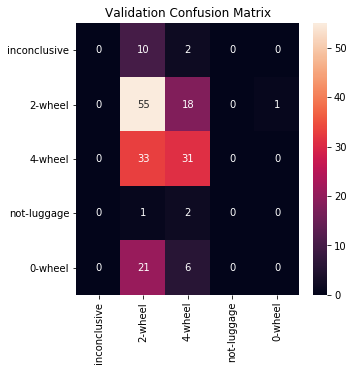

Epoch 12, training loss: 1.16, validation loss: 1.20, training accuracy: 0.48, validation accuracy: 0.39


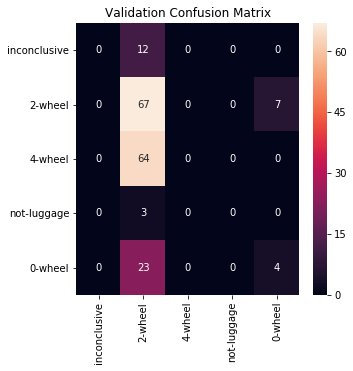

Epoch 13, training loss: 1.15, validation loss: 1.29, training accuracy: 0.45, validation accuracy: 0.40


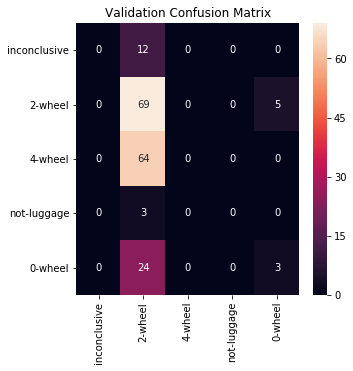

Epoch 14, training loss: 1.17, validation loss: 1.25, training accuracy: 0.46, validation accuracy: 0.49


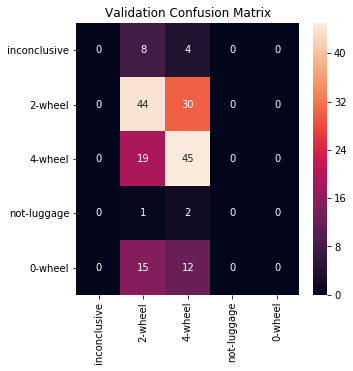

Epoch 15, training loss: 1.17, validation loss: 1.10, training accuracy: 0.50, validation accuracy: 0.51


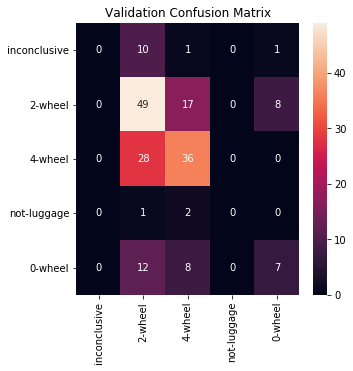

Epoch 16, training loss: 1.08, validation loss: 1.15, training accuracy: 0.52, validation accuracy: 0.44


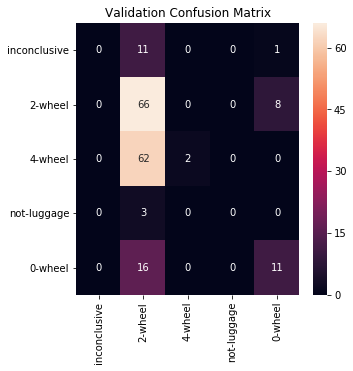

Epoch 17, training loss: 1.07, validation loss: 1.07, training accuracy: 0.51, validation accuracy: 0.52


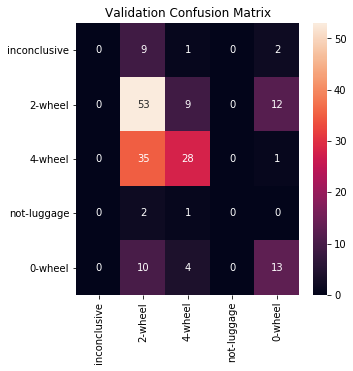

Epoch 18, training loss: 1.09, validation loss: 1.06, training accuracy: 0.51, validation accuracy: 0.50


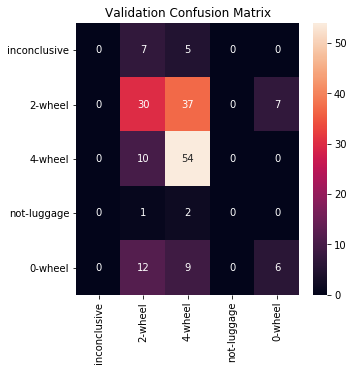

Epoch 19, training loss: 1.03, validation loss: 1.08, training accuracy: 0.54, validation accuracy: 0.54


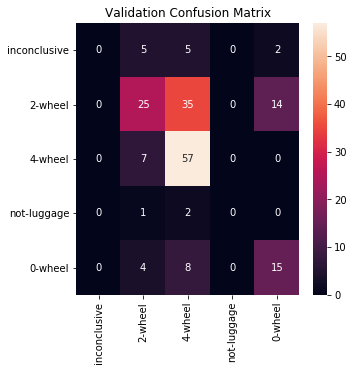

Epoch 20, training loss: 0.99, validation loss: 1.00, training accuracy: 0.56, validation accuracy: 0.57


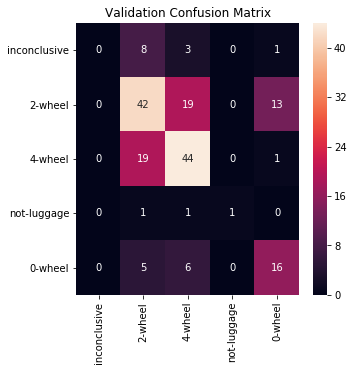

Epoch 21, training loss: 0.91, validation loss: 0.98, training accuracy: 0.60, validation accuracy: 0.61


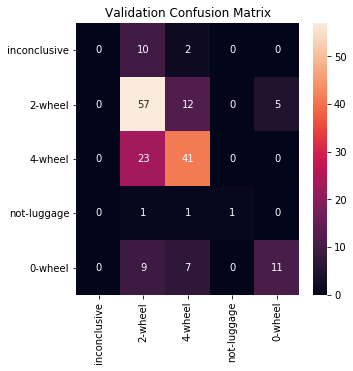

Epoch 22, training loss: 1.09, validation loss: 1.04, training accuracy: 0.55, validation accuracy: 0.56


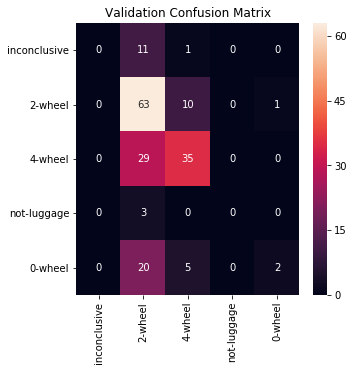

Epoch 23, training loss: 0.97, validation loss: 0.97, training accuracy: 0.57, validation accuracy: 0.58


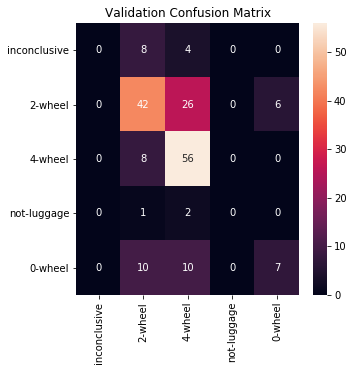

Epoch 24, training loss: 0.88, validation loss: 0.94, training accuracy: 0.63, validation accuracy: 0.59


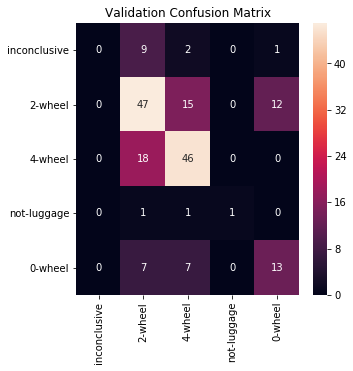

Epoch 25, training loss: 0.82, validation loss: 1.10, training accuracy: 0.65, validation accuracy: 0.49


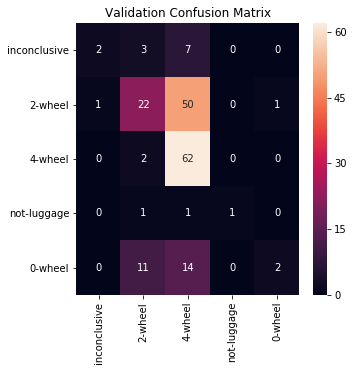

Epoch 26, training loss: 0.81, validation loss: 1.05, training accuracy: 0.68, validation accuracy: 0.52


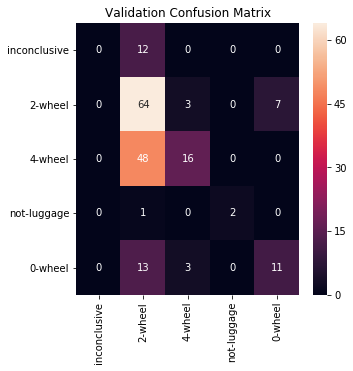

Epoch 27, training loss: 0.85, validation loss: 0.91, training accuracy: 0.66, validation accuracy: 0.62


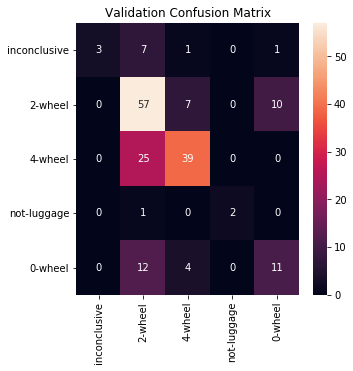

Epoch 28, training loss: 0.73, validation loss: 0.92, training accuracy: 0.70, validation accuracy: 0.63


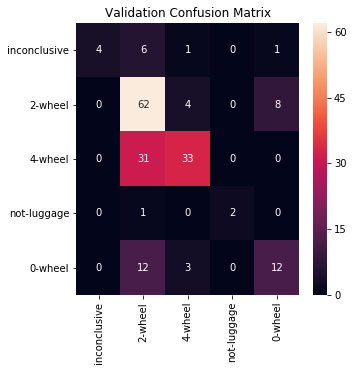

Epoch 29, training loss: 0.67, validation loss: 0.99, training accuracy: 0.72, validation accuracy: 0.61


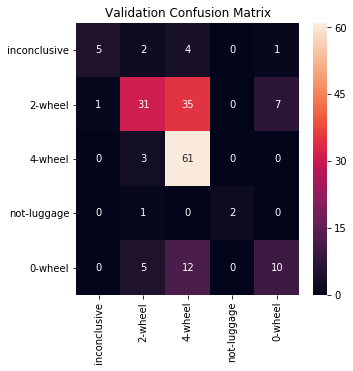

Epoch 30, training loss: 0.67, validation loss: 0.85, training accuracy: 0.74, validation accuracy: 0.68


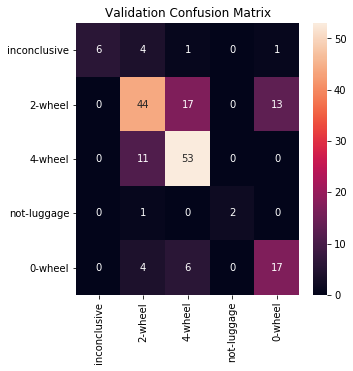

Epoch 31, training loss: 0.58, validation loss: 0.91, training accuracy: 0.79, validation accuracy: 0.67


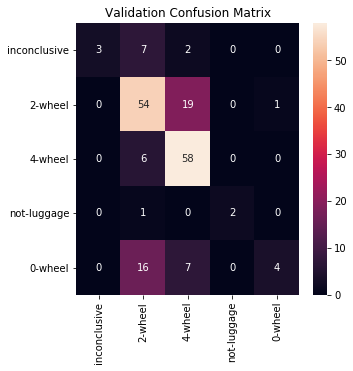

Epoch 32, training loss: 0.55, validation loss: 1.04, training accuracy: 0.79, validation accuracy: 0.56


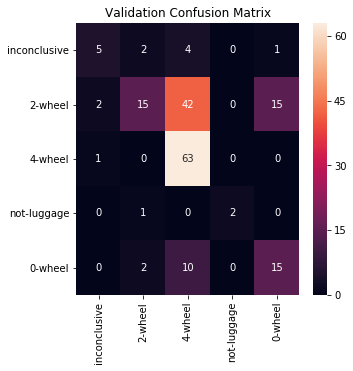

Epoch 33, training loss: 0.57, validation loss: 0.81, training accuracy: 0.78, validation accuracy: 0.71


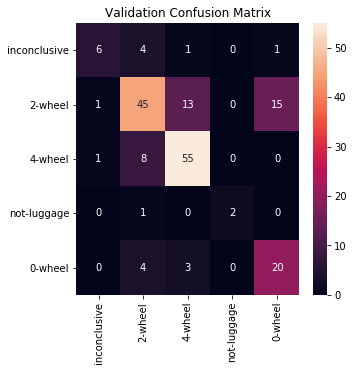

Epoch 34, training loss: 0.47, validation loss: 0.92, training accuracy: 0.82, validation accuracy: 0.64


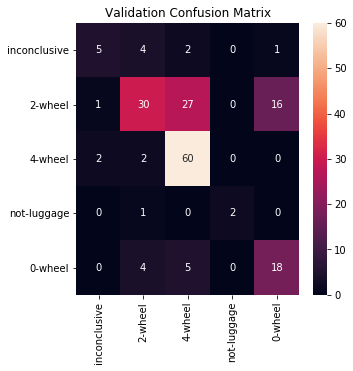

Epoch 35, training loss: 0.47, validation loss: 0.84, training accuracy: 0.83, validation accuracy: 0.70


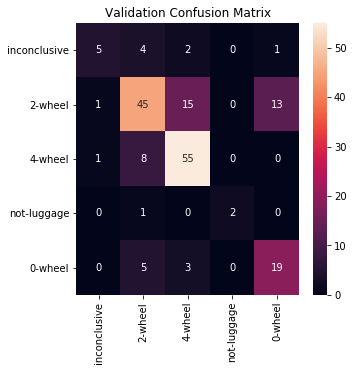

Epoch 36, training loss: 0.41, validation loss: 0.89, training accuracy: 0.84, validation accuracy: 0.70


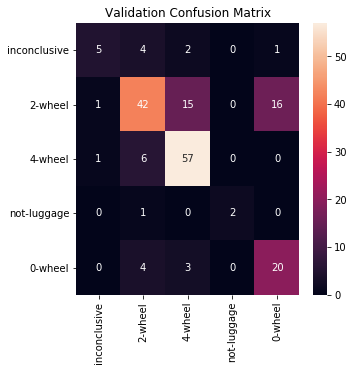

Epoch 37, training loss: 0.41, validation loss: 0.81, training accuracy: 0.85, validation accuracy: 0.72


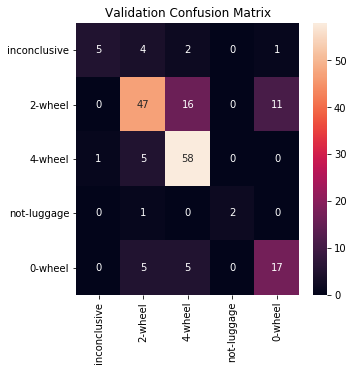

Epoch 38, training loss: 0.34, validation loss: 0.86, training accuracy: 0.88, validation accuracy: 0.70


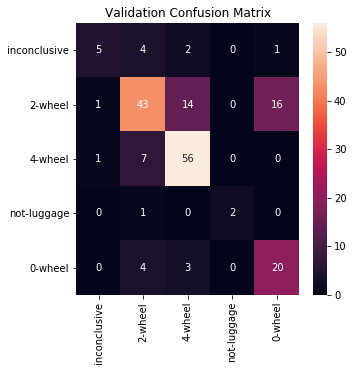

Epoch 39, training loss: 0.24, validation loss: 0.92, training accuracy: 0.93, validation accuracy: 0.71


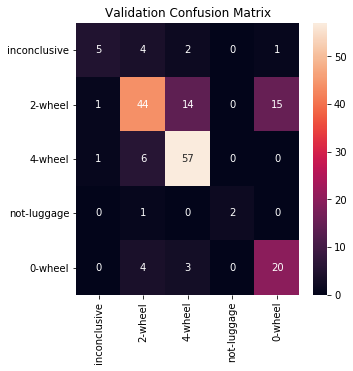

Epoch 40, training loss: 0.34, validation loss: 0.87, training accuracy: 0.87, validation accuracy: 0.70


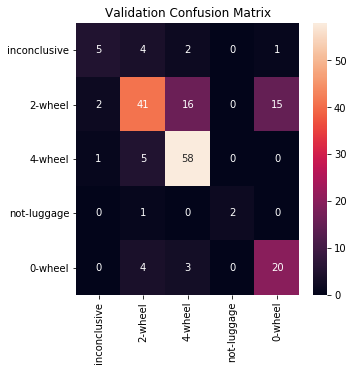

Epoch 41, training loss: 0.21, validation loss: 0.94, training accuracy: 0.95, validation accuracy: 0.71


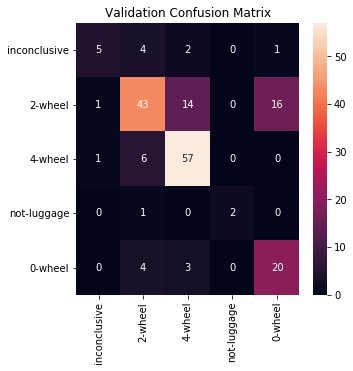

Epoch 42, training loss: 0.15, validation loss: 0.95, training accuracy: 0.97, validation accuracy: 0.72


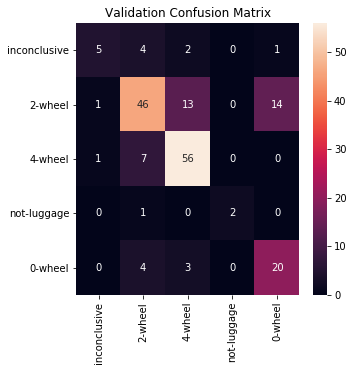

Epoch 43, training loss: 0.18, validation loss: 0.91, training accuracy: 0.94, validation accuracy: 0.70


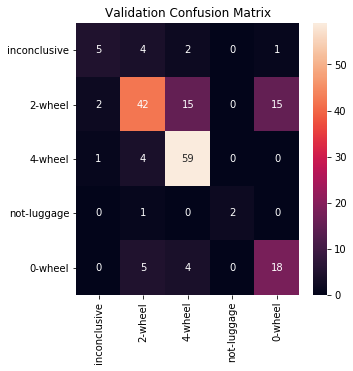

Epoch 44, training loss: 0.15, validation loss: 0.93, training accuracy: 0.97, validation accuracy: 0.71


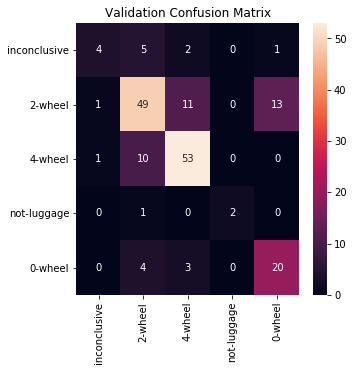

Epoch 45, training loss: 0.29, validation loss: 1.32, training accuracy: 0.89, validation accuracy: 0.57


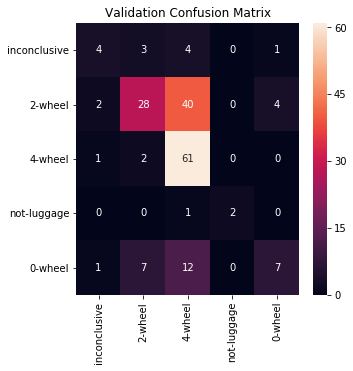

Epoch 46, training loss: 0.24, validation loss: 0.89, training accuracy: 0.93, validation accuracy: 0.71


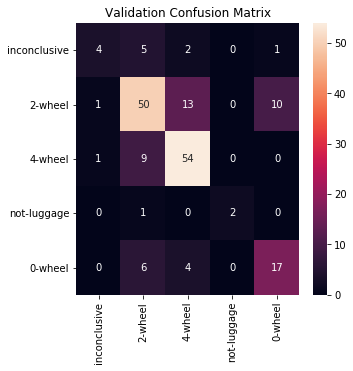

Epoch 47, training loss: 0.10, validation loss: 1.08, training accuracy: 0.98, validation accuracy: 0.68


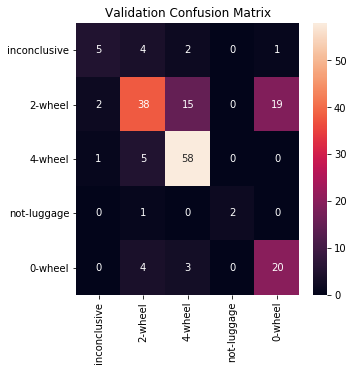

Epoch 48, training loss: 0.33, validation loss: 0.91, training accuracy: 0.90, validation accuracy: 0.70


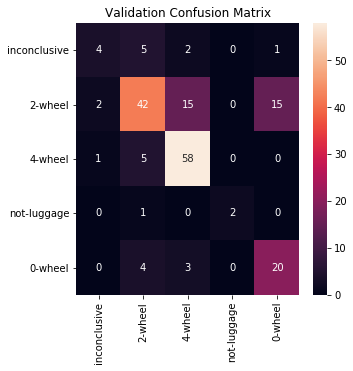

Epoch 49, training loss: 0.10, validation loss: 1.07, training accuracy: 0.99, validation accuracy: 0.70


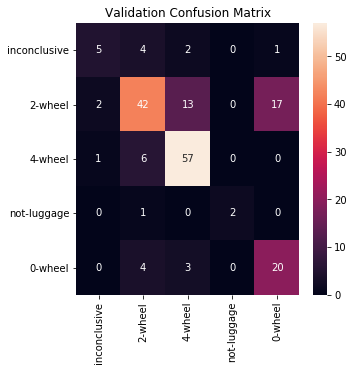

In [42]:
import mxnet as mx
from mxnet import gluon, autograd, ndarray
from mxnet.gluon.loss import SoftmaxCrossEntropyLoss
import mxnet.ndarray as nd
from sklearn.metrics import accuracy_score

# Set this to CPU or GPU depending on your training instance
# ctx = mx.cpu()
ctx = mx.gpu()

# Hyper-paramaters of the system
batch_size = 250
epochs = 50
learning_rate = 0.035

# Create the network. We have 5 classes
num_outputs = 5
    
net = gluon.nn.Sequential()
with net.name_scope():
    net.add(gluon.nn.Conv2D(channels=20, kernel_size=5, activation='relu'))
    net.add(gluon.nn.MaxPool2D(pool_size=2, strides=2))
    net.add(gluon.nn.Conv2D(channels=60, kernel_size=3, activation='relu'))
    net.add(gluon.nn.MaxPool2D(pool_size=2, strides=2))
    # The Flatten layer collapses all axis, except the first one, into one axis.
    net.add(gluon.nn.Flatten())
    net.add(gluon.nn.Dense(512, activation="relu"))
    net.add(gluon.nn.Dense(num_outputs))
    
# Initialize parameters
net.collect_params().initialize(mx.init.Xavier(magnitude=2.24), ctx=ctx)

# Define loss and trainer.
softmax_cross_etropy_loss = gluon.loss.SoftmaxCrossEntropyLoss()
trainer = gluon.Trainer(net.collect_params(), 'sgd', {'learning_rate': learning_rate})

# Starting the outer loop, we will have 30 epochs (30 full pass through our dataset)
for epoch in range(epochs):
    
    # Training loop: (with autograd and trainer steps, etc.)
    # This loop does the training of the neural network (weights are updated)
    cumulative_train_loss = 0
    train_predictions = []
    for i in range(0, train_images.shape[0], batch_size):
        data = nd.array(train_images[i:i + batch_size].astype('float32')).as_in_context(ctx)
        label = nd.array(train_labels[i:i + batch_size]).as_in_context(ctx)
        with autograd.record():
            output = net(data)
            train_predictions = train_predictions + np.argmax(output.asnumpy(), axis=1).tolist()
            loss = softmax_cross_etropy_loss(output, label)
            cumulative_train_loss = cumulative_train_loss + nd.sum(loss)
        loss.backward()
        trainer.step(data.shape[0])
    
    # Calculating the Softmax Cross Entopy Loss for training
    train_loss = cumulative_train_loss/len(train_images)

    # Validation loop:
    # This loop tests the trained network on validation dataset
    # No weight updates here
    cumulative_valid_loss = 0
    val_predictions = []
    for i in range(0, validation_images.shape[0], batch_size):
        data = nd.array(validation_images[i:i + batch_size].astype('float32')).as_in_context(ctx)
        label = nd.array(validation_labels[i:i + batch_size]).as_in_context(ctx)
        output = net(data)
        val_predictions = val_predictions + np.argmax(output.asnumpy(), axis=1).tolist()
        val_loss = softmax_cross_etropy_loss(output, label)
        cumulative_valid_loss = cumulative_valid_loss + nd.sum(val_loss)
    valid_loss = cumulative_valid_loss/len(validation_images)

    # Calculate training and validation accuracies
    # I used a accuracy_score() function from the sklearn library here. 
    # accuracy = (TP+TN) / (TP+FP+TN+FN)
    train_accuracy = accuracy_score(train_labels.tolist(), train_predictions)
    validation_accuracy = accuracy_score(validation_labels.tolist(), val_predictions)
    
    # Print the summary and plot the confusion matrix after each epoch
    print("Epoch {}, training loss: {:.2f}, validation loss: {:.2f}, training accuracy: {:.2f}, validation accuracy: {:.2f}".format(epoch, train_loss.asnumpy()[0], valid_loss.asnumpy()[0], train_accuracy, validation_accuracy))
    plot_confusion_matrix(validation_labels.tolist(), val_predictions)

### 6. Test on test dataset
#### We are done with the training and validation. Let's get the test predictions below. We will also write them to a __CSV__ file in a similar way to our __Final Project__. 

In [20]:
test_images = getImages(test_df["data"].values)
test_predictions = []
for i in range(0, test_images.shape[0], batch_size):
    data = nd.array(test_images[i:i + batch_size].astype('float32')).as_in_context(ctx)
    output = net(data)
    test_predictions = test_predictions + np.argmax(output.asnumpy(), axis=1).tolist()
print(test_predictions)

[4, 1, 1, 2, 2, 1, 2, 1, 4, 1, 2, 4, 2, 1, 1, 2, 1, 1, 2, 1, 2, 4, 4, 1, 2, 2, 1, 1, 4, 1, 1, 3, 4, 2, 1, 0, 2, 1, 3, 2, 2, 1, 1, 1, 1, 2, 2, 1, 2, 4, 1, 4, 2, 1, 1, 1, 1, 2, 2, 1, 1, 4, 1, 2, 2, 0, 1, 1, 1, 2, 4, 1, 4, 1, 1, 1, 1, 4, 1, 1, 4, 2, 1, 4, 4, 4, 1, 4, 2, 4, 1, 1, 1, 2, 2, 2, 1, 1, 2, 4, 1, 1, 4, 2, 1, 2, 1, 1, 2, 1, 1, 1, 1, 2, 1, 2, 2, 2, 2, 1, 2, 2, 2, 2, 2, 1, 4, 1, 4, 4, 4, 1, 2, 4, 2, 2, 4, 1, 2, 4, 2, 2, 4, 2, 2, 1, 4, 2, 2, 2, 1, 1, 4, 4, 4, 2, 1, 1, 3, 2, 4, 2, 1, 2, 1, 1, 4, 1, 4, 2, 2, 1, 2, 2, 4, 4, 3, 1, 1, 4, 2, 1, 2, 1, 1, 2, 2, 4, 2, 4, 4, 2, 1, 1, 4, 1, 1, 4, 1, 1, 1, 1, 2, 2, 1, 2, 1, 1, 4, 4, 1, 2, 2, 2, 2, 1, 2, 2, 1, 1, 1, 1, 2, 1, 4, 1, 2, 4, 1, 1, 2, 2, 1, 1, 1, 2, 1, 1, 2, 4, 2, 1, 2, 2, 1, 1, 1, 2, 4, 2, 2, 1, 4, 2, 1, 1, 4, 4, 1, 2, 4, 2, 4, 1, 4, 2, 1, 2, 2, 2, 1, 4, 2, 1, 1, 1, 0, 1, 4, 4, 1, 1, 2, 1, 4, 1, 2, 0, 1, 1, 1, 1, 2, 1, 1, 3, 2, 2, 2, 1, 2, 1, 2, 1, 4, 1, 1, 2, 4, 0, 2, 4, 2, 1, 2, 1, 1, 4, 1, 1, 4, 1, 1, 1, 2, 2, 2, 1, 2, 2, 2, 4, 4, 

In [21]:
import pandas as pd

result_df = pd.DataFrame(columns=['ID', 'label'])
result_df["ID"] = test_df["ID"]
result_df["label"] = test_predictions

result_df.to_csv("./results_cv_example-4.csv", index=False)